# Single Person Pose Estimation
Developed by Marcelo Rovai - 19Aug20

- General theory: [Real-time Human Pose Estimation in the Browser with TensorFlow.js](https://medium.com/tensorflow/real-time-human-pose-estimation-in-the-browser-with-tensorflow-js-7dd0bc881cd5)
- [PoseNet GitHub](https://github.com/tensorflow/tfjs-models/tree/master/posenet)
- Some Python functions based on [Ivan Kunyakin](https://medium.com/@ikunyankin?source=post_page-----ea2e9249abbd----------------------) tutorial: [Pose estimation and matching with TensorFlow lite ](https://medium.com/roonyx/pose-estimation-and-matching-with-tensorflow-lite-posenet-model-ea2e9249abbd)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tflite_runtime.interpreter as tflite

In [4]:
!ls ./models

posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite


## Initialize the TFLite interpreter to try it out

In [5]:
# Load TFLite model and allocate tensors.
interpreter = tflite.Interpreter(
    model_path=
    './models/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite')
interpreter.allocate_tensors()

In [6]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [7]:
input_details

[{'name': 'sub_2',
  'index': 93,
  'shape': array([  1, 257, 257,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}}]

In [8]:
output_details

[{'name': 'MobilenetV1/heatmap_2/BiasAdd',
  'index': 87,
  'shape': array([ 1,  9,  9, 17]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}},
 {'name': 'MobilenetV1/offset_2/BiasAdd',
  'index': 90,
  'shape': array([ 1,  9,  9, 34]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}},
 {'name': 'MobilenetV1/displacement_fwd_2/BiasAdd',
  'index': 84,
  'shape': array([ 1,  9,  9, 32]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}},
 {'name': 'MobilenetV1/displacement_bwd_2/BiasAdd',
  'index': 81,
  'shape': array([ 1,  9,  9, 32]),
  'dtype': numpy.float32,
  

## Test the TensorFlow Lite model

In [9]:
input_shape = input_details[0]['shape']
input_shape

array([  1, 257, 257,   3])

In [10]:
img_size = input_shape[:2] if len(input_shape) == 3 else input_shape[1:3]
size = img_size[0],img_size[1]
size

(257, 257)

In [11]:
!ls ./images

C2F_JS_Example.png	  charlie_chaplin_PNG1.png
charlie-5275641_1920.png  Einstein_Le_Corbusier_Princeton_1946.jpg
charlie-5275641_640.png   einstein_oxford.jpg
charlie_chaplin_free.png  figure-836178_1920.jpg
charlie-chaplin.jpg	  human.png
Charlie_Chaplin.jpg	  tango.jpg


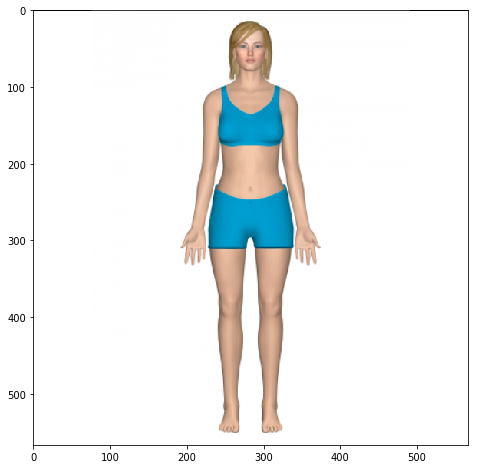

In [21]:
image_path = './images/human.png'
plt.figure(figsize=(15,8))
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

### Pre-Process Image

In [22]:
image = cv2.resize(image, size) 
input_data = np.expand_dims(image, axis=0)
input_data = input_data.astype(np.float32)
input_data.shape

(1, 257, 257, 3)

In [23]:
input_data = (np.float32(input_data) - 127.5) / 127.5

In [24]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

The output consist of 2 parts:
- heatmaps (9,9,17) - corresponds to the probability of appearance of each keypoint in the particular part of the image (9,9), without applying sigmoid function. Is used to locate the approximate position of the joint
- offset vectors (9,9,34) is called offset vectors. Is used for more exact calculation of the keypoint's position. First 17 of the third dimension correspond to the x coordinates and the second 17 of them correspond to the y coordinates

In [25]:
output_details = interpreter.get_output_details()[0]
heatmaps = np.squeeze(interpreter.get_tensor(output_details['index']))
heatmaps.shape

(9, 9, 17)

In [26]:
output_details = interpreter.get_output_details()[1]
offsets = np.squeeze(interpreter.get_tensor(output_details['index']))
offsets.shape

(9, 9, 34)

In [27]:
heatmaps[:,:,0]

array([[ -9.17713  ,  -8.675294 , -12.592056 , -11.383918 ,  -1.8177485,
         -8.970477 ,  -8.130428 ,  -6.704365 ,  -7.4828587],
       [ -6.375972 ,  -6.297804 , -11.883587 ,  -6.0580816,   6.606324 ,
         -4.315241 ,  -9.474827 ,  -7.06845  ,  -7.2061644],
       [ -8.804461 ,  -8.813535 ,  -9.506746 ,  -7.7161636,  -6.2782736,
         -8.136768 , -10.635923 , -11.656    ,  -8.129082 ],
       [ -9.640908 , -10.219561 , -10.3519745,  -7.444356 ,  -7.7237606,
         -6.361947 , -10.237825 ,  -8.971716 ,  -9.457554 ],
       [ -9.588207 , -11.278203 , -11.007669 ,  -8.718188 ,  -8.421213 ,
         -9.406428 , -11.541677 ,  -8.998726 ,  -8.4198265],
       [ -9.1705065, -11.665849 , -12.361076 ,  -6.2816267,  -7.211874 ,
         -8.556076 , -12.724236 ,  -9.988138 ,  -8.543639 ],
       [ -8.839208 , -10.264835 , -12.997759 , -11.004988 , -10.037951 ,
         -9.57799  , -11.202278 , -13.714579 ,  -9.972307 ],
       [ -9.052969 , -10.637996 ,  -9.2329445,  -9.88553  ,  -

In [28]:
# another way to get data
heatmaps[..., 0]

array([[ -9.17713  ,  -8.675294 , -12.592056 , -11.383918 ,  -1.8177485,
         -8.970477 ,  -8.130428 ,  -6.704365 ,  -7.4828587],
       [ -6.375972 ,  -6.297804 , -11.883587 ,  -6.0580816,   6.606324 ,
         -4.315241 ,  -9.474827 ,  -7.06845  ,  -7.2061644],
       [ -8.804461 ,  -8.813535 ,  -9.506746 ,  -7.7161636,  -6.2782736,
         -8.136768 , -10.635923 , -11.656    ,  -8.129082 ],
       [ -9.640908 , -10.219561 , -10.3519745,  -7.444356 ,  -7.7237606,
         -6.361947 , -10.237825 ,  -8.971716 ,  -9.457554 ],
       [ -9.588207 , -11.278203 , -11.007669 ,  -8.718188 ,  -8.421213 ,
         -9.406428 , -11.541677 ,  -8.998726 ,  -8.4198265],
       [ -9.1705065, -11.665849 , -12.361076 ,  -6.2816267,  -7.211874 ,
         -8.556076 , -12.724236 ,  -9.988138 ,  -8.543639 ],
       [ -8.839208 , -10.264835 , -12.997759 , -11.004988 , -10.037951 ,
         -9.57799  , -11.202278 , -13.714579 ,  -9.972307 ],
       [ -9.052969 , -10.637996 ,  -9.2329445,  -9.88553  ,  -

In [29]:
heatmaps[:,:,0].max()

6.606324

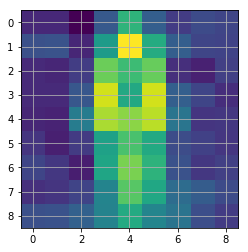

In [30]:
max_prob = np.amax(heatmaps[:, :, :-1], axis=2)
plt.imshow(max_prob)
plt.grid();

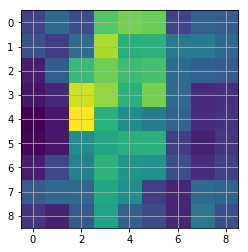

In [31]:
max_prob = np.amax(offsets[:, :, :-1], axis=2)
plt.imshow(max_prob)
plt.grid();

In [32]:
heatmaps.shape[-1]

17

Functions based on [Ivan Kunyakin](https://medium.com/@ikunyankin?source=post_page-----ea2e9249abbd----------------------) tutorial: [Pose estimation and matching with TensorFlow lite ](https://medium.com/roonyx/pose-estimation-and-matching-with-tensorflow-lite-posenet-model-ea2e9249abbd)

In [33]:
def get_keypoints(heatmaps, offsets):

    joint_num = heatmaps.shape[-1]
    pose_kps = np.zeros((joint_num, 2), np.uint32)
    max_prob = np.zeros((joint_num, 1))

    for i in range(joint_num):

        joint_heatmap = heatmaps[:,:,i]
        max_val_pos = np.squeeze(
            np.argwhere(joint_heatmap == np.max(joint_heatmap)))
        remap_pos = np.array(max_val_pos / 8 * 257, dtype=np.int32)
        pose_kps[i, 0] = int(remap_pos[0] +
                             offsets[max_val_pos[0], max_val_pos[1], i])
        pose_kps[i, 1] = int(remap_pos[1] +
                             offsets[max_val_pos[0], max_val_pos[1],
                                         i + joint_num])
        max_prob[i] = np.amax(joint_heatmap)

    return pose_kps, max_prob

In [34]:
keypts_array, max_prob = get_keypoints(heatmaps,offsets)

In [35]:
keypts_array

array([[ 27, 128],
       [ 22, 132],
       [ 22, 123],
       [ 26, 138],
       [ 26, 115],
       [ 50, 145],
       [ 50, 110],
       [ 86, 153],
       [ 92, 100],
       [121, 159],
       [124,  94],
       [118, 143],
       [117, 113],
       [177, 140],
       [177, 117],
       [234, 144],
       [234, 117]], dtype=uint32)

In [36]:
max_prob

array([[6.6063242 ],
       [4.49711084],
       [4.90882874],
       [0.57633817],
       [1.18327284],
       [2.60467553],
       [2.71162415],
       [5.4410305 ],
       [5.44809055],
       [4.8336916 ],
       [4.4214325 ],
       [2.98301768],
       [3.60703087],
       [2.25849795],
       [3.14043045],
       [2.14061618],
       [2.80984974]])

In [37]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(257, 257, 3)

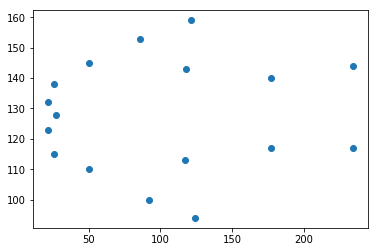

In [38]:
plt.scatter(*zip(*keypts_array))

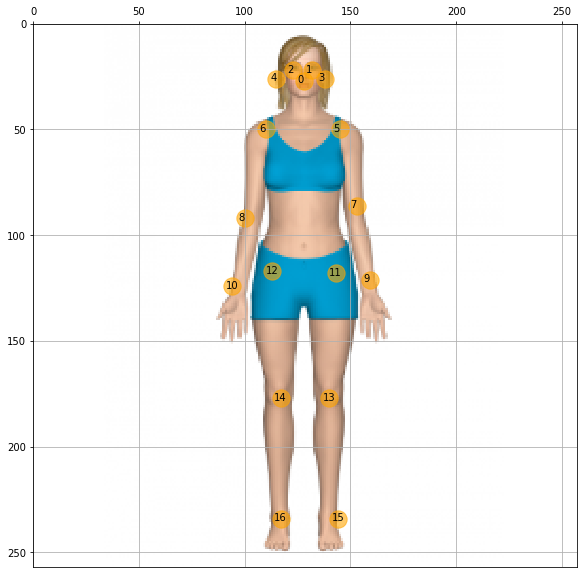

In [39]:
y,x = zip(*keypts_array)
plt.figure(figsize=(10,10))
plt.axis([0, image.shape[1], 0, image.shape[0]])  
plt.scatter(x,y, s=300, color='orange', alpha=0.6)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
ax=plt.gca() 
ax.set_ylim(ax.get_ylim()[::-1]) 
ax.xaxis.tick_top() 
plt.grid();

for i, txt in enumerate(keypts_array):
    ax.annotate(i, (keypts_array[i][1]-3, keypts_array[i][0]+1))

In [42]:
def join_point(img, kps, color='white', bone_size=1):
    
    if   color == 'blue'  : color=(255, 0, 0)
    elif color == 'green': color=(0, 255, 0)
    elif color == 'red':  color=(0, 0, 255)
    elif color == 'white': color=(255, 255, 255)
    else:                  color=(0, 0, 0)

    body_parts = [(5, 6), (5, 7), (6, 8), (7, 9), (8, 10), (11, 12), (5, 11),
                  (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

    for part in body_parts:
        cv2.line(img, (kps[part[0]][1], kps[part[0]][0]),
                (kps[part[1]][1], kps[part[1]][0]),
                color=color,
                lineType=cv2.LINE_AA,
                thickness=bone_size)
    
    for i in range(0,len(kps)):
        cv2.circle(img,(kps[i,1],kps[i,0]),2,(255,0,0),-1)

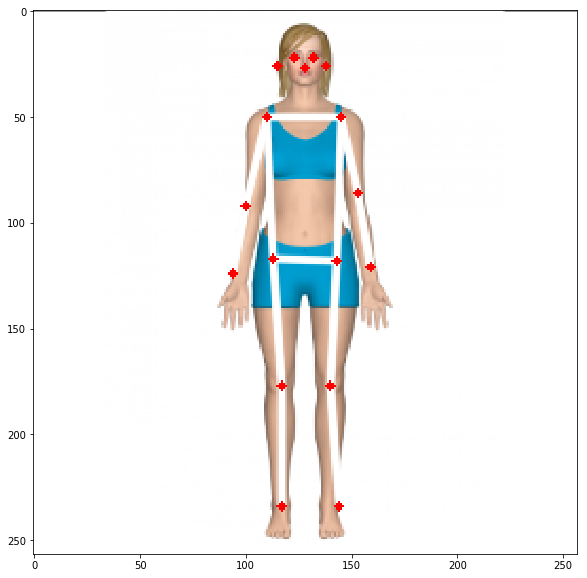

In [43]:
join_point(img, keypts_array, bone_size=2)
plt.figure(figsize=(10,10))
plt.imshow(img);

In [47]:
def plot_pose(img, keypts_array, joint_color='red', bone_color='blue', bone_size=1):
    join_point(img, keypts_array, bone_color, bone_size)
    y,x = zip(*keypts_array)
    plt.figure(figsize=(10,10))
    plt.axis([0, img.shape[1], 0, img.shape[0]])  
    plt.scatter(x,y, s=100, color=joint_color)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    ax=plt.gca() 
    ax.set_ylim(ax.get_ylim()[::-1]) 
    ax.xaxis.tick_top() 
    plt.grid();
    return img

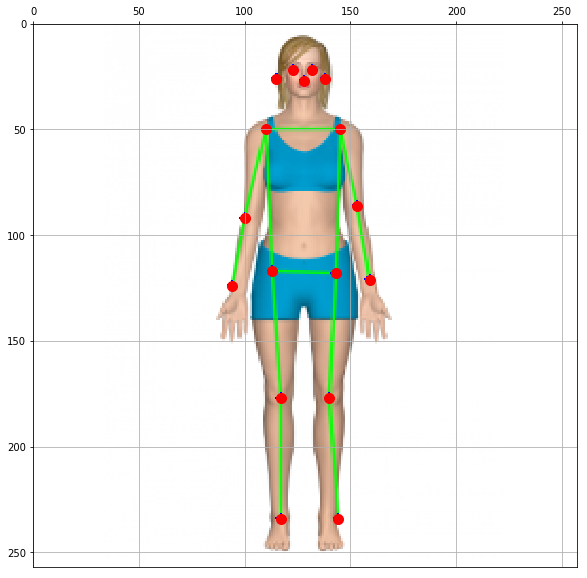

In [48]:
img = plot_pose(image, keypts_array, bone_color='green', bone_size=1)

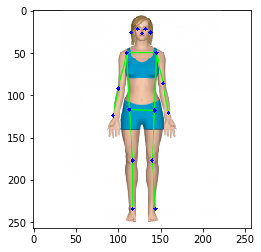

In [49]:
plt.imshow(img)

## Building a general function

In [50]:
image_path = './images/human.png'

In [51]:
image_original = cv2.imread(image_path)

In [52]:
image_original.shape

(567, 567, 3)

In [53]:
wo = image_original.shape[1]
ho = image_original.shape[0]
wo,ho

(567, 567)

In [54]:
w = size[1]
h = size[0]
w,h

(257, 257)

In [55]:
keypts_array

array([[ 27, 128],
       [ 22, 132],
       [ 22, 123],
       [ 26, 138],
       [ 26, 115],
       [ 50, 145],
       [ 50, 110],
       [ 86, 153],
       [ 92, 100],
       [121, 159],
       [124,  94],
       [118, 143],
       [117, 113],
       [177, 140],
       [177, 117],
       [234, 144],
       [234, 117]], dtype=uint32)

In [56]:
a = keypts_array
b = np.array([(ho/h), (wo/h)])
np.multiply(a,b).astype(int)

array([[ 59, 282],
       [ 48, 291],
       [ 48, 271],
       [ 57, 304],
       [ 57, 253],
       [110, 319],
       [110, 242],
       [189, 337],
       [202, 220],
       [266, 350],
       [273, 207],
       [260, 315],
       [258, 249],
       [390, 308],
       [390, 258],
       [516, 317],
       [516, 258]])

In [57]:
def get_original_pose_keypoints(image_original, keypts_array, size):
    wo = image_original.shape[1]
    ho = image_original.shape[0]
    w = size[1]
    h = size[0]
    b = np.array([(ho/h), (wo/h)])
    orig_kps = np.multiply(keypts_array,b).astype(int)
    return orig_kps

In [58]:
get_original_pose_keypoints(image_original, keypts_array, size)

array([[ 59, 282],
       [ 48, 291],
       [ 48, 271],
       [ 57, 304],
       [ 57, 253],
       [110, 319],
       [110, 242],
       [189, 337],
       [202, 220],
       [266, 350],
       [273, 207],
       [260, 315],
       [258, 249],
       [390, 308],
       [390, 258],
       [516, 317],
       [516, 258]])

In [59]:
def get_plot_pose(image_path, size, joint_color='red', bone_color='blue', bone_size=1):    
    image_original = cv2.imread(image_path)
    image = cv2.resize(image_original, size) 
    input_data = np.expand_dims(image, axis=0)
    input_data = input_data.astype(np.float32)
    input_data = (np.float32(input_data) - 127.5) / 127.5

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    output_details = interpreter.get_output_details()[0]
    heatmaps = np.squeeze(interpreter.get_tensor(output_details['index']))

    output_details = interpreter.get_output_details()[1]
    offsets = np.squeeze(interpreter.get_tensor(output_details['index']))

    keypts_array, max_prob = get_keypoints(heatmaps,offsets)
    orig_kps = get_original_pose_keypoints(image_original, keypts_array, size)

    img = plot_pose(image_original, orig_kps, joint_color, bone_color, bone_size)
    
    return orig_kps, max_prob, img

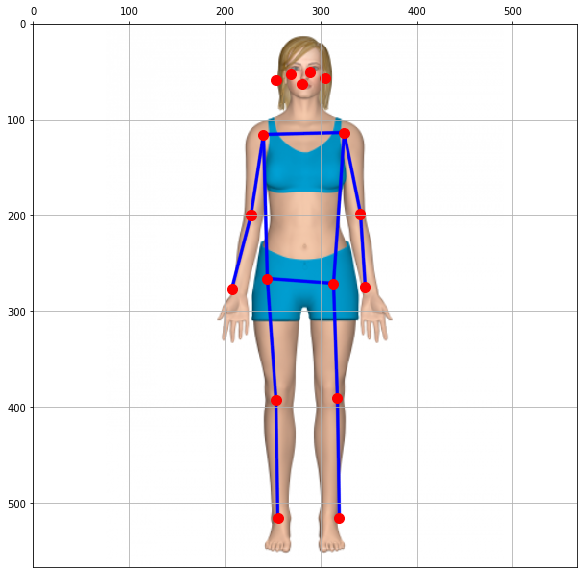

In [61]:
orig_kps, max_prob, img = get_plot_pose(image_path, size, bone_color='blue', bone_size=2)

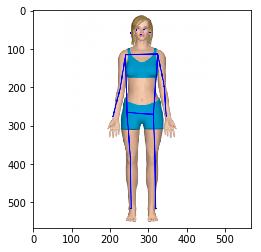

In [45]:
plt.imshow(img)

## Testing on other images

In [46]:
! ls ./images/

C2F_JS_Example.png	  charlie_chaplin_PNG1.png
charlie-5275641_1920.png  Einstein_Le_Corbusier_Princeton_1946.jpg
charlie-5275641_640.png   einstein_oxford.jpg
charlie_chaplin_free.png  figure-836178_1920.jpg
charlie-chaplin.jpg	  human.png
Charlie_Chaplin.jpg	  tango.jpg


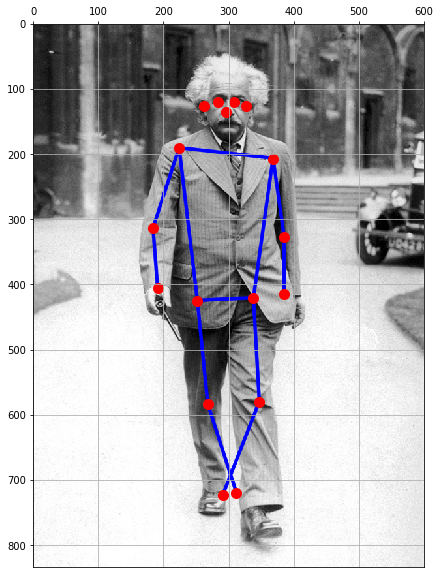

In [62]:
image_path = './images/einstein_oxford.jpg'
keypts_array, max_prob, img  = get_plot_pose(image_path, size, bone_size=3)

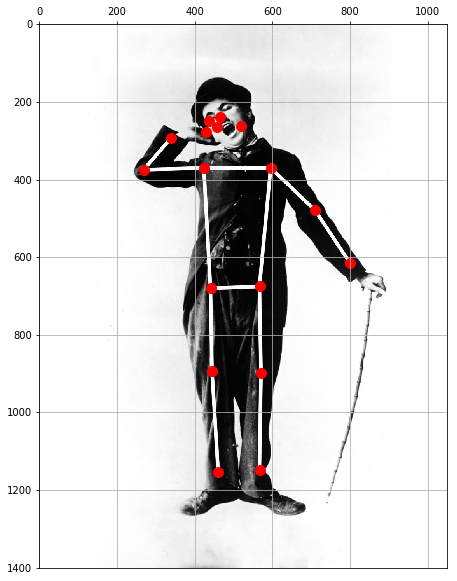

In [63]:
image_path = './images/Charlie_Chaplin.jpg'
keypts_array, max_prob, img = get_plot_pose(image_path, size, bone_color='white', bone_size=8)

CPU times: user 621 ms, sys: 109 ms, total: 730 ms
Wall time: 454 ms


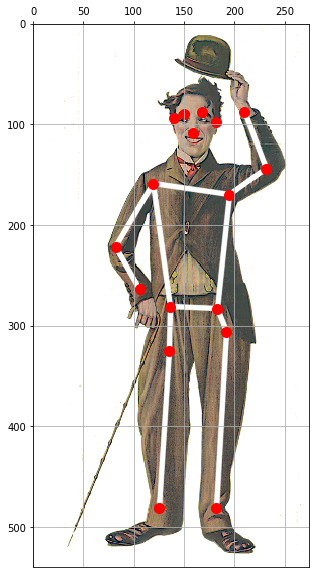

In [64]:
image_path = './images/charlie-5275641_1920.png'
%time keypts_array, max_prob, img = get_plot_pose(image_path, size, bone_color='white', bone_size=4)

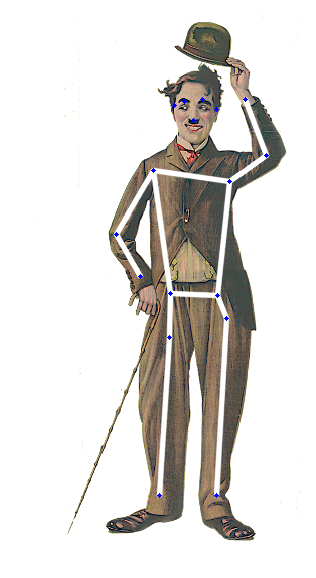

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off');